### Gitika Jha -- U10690464

### CS/DS 549 -- HW1 - Part 2 -- ML Programming

##### As I am working on my local machine, my environment is local


##### The first step is to download packages, do all imports and then read the files. I am appending all of the file content into a list

In [2]:
# installing modules relevant to this assignment

%pip install nltk
%pip install scikit-learn
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
# all imports

import os
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

import re

import pandas as pd
from wordcloud import WordCloud

from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from wordcloud import WordCloud

In [4]:
# nltk packages

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GJ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# get all urls from repo_list.txt

with open("repo_list.txt", "r") as file:
    repository_links = file.read().splitlines()

repository_links

['https://github.com/project-akri/akri',
 'https://github.com/cdk8s-team/cdk8s',
 'https://github.com/cloud-custodian/cloud-custodian',
 'https://github.com/devstream-io/devstream',
 'https://github.com/GoogleContainerTools/kpt',
 'https://github.com/kubedl-io/kubedl',
 'https://github.com/kubeedge/kubeedge',
 'https://github.com/meshery/meshery',
 'https://github.com/metal3-io/baremetal-operator',
 'https://github.com/openyurtio/openyurt',
 'https://github.com/superedge/superedge',
 'https://github.com/tinkerbell/tink',
 'https://github.com/distribution/distribution',
 'https://github.com/dragonflyoss/Dragonfly2',
 'https://github.com/goharbor/harbor',
 'https://github.com/project-zot/zot',
 'https://github.com/cert-manager/cert-manager',
 'https://github.com/confidential-containers/operator',
 'https://github.com/containerssh/containerssh',
 'https://github.com/curiefense/curiefense',
 'https://github.com/dexidp/dex',
 'https://github.com/external-secrets/external-secrets',
 'https:/

Reading all of these files in the raw format and combining them in a list

In [26]:
unpreprocessed_readmes = []

for url in repository_links:
    repo_name = url.split("/")[-1]
    readme_path = os.path.join("readmes", f"{repo_name}_README.md")
    if os.path.exists(readme_path):
        with open(readme_path, "r", encoding="utf-8") as file:
            readme_text = file.read()
            unpreprocessed_readmes.append(readme_text)

unpreprocessed_readmes

['<p align="center"><img src="https://github.com/project-akri/akri-docs/blob/main/art/logo-horizontal/akri-logo-horizontal-light.svg" alt="Akri Logo" width="300"></p>\n\n[![Slack channel #akri](https://img.shields.io/badge/slack-akri-blueviolet.svg?logo=slack)](https://kubernetes.slack.com/messages/akri)\n[![Rust Version](https://img.shields.io/badge/rustc-1.68.1-blue.svg)](https://blog.rust-lang.org/2023/03/31/Rust-1.68.1.html)\n[![Kubernetes Version](https://img.shields.io/badge/kubernetes-≥%201.16-blue.svg)](https://kubernetes.io/)\n[![codecov](https://codecov.io/gh/project-akri/akri/branch/main/graph/badge.svg?token=V468HO7CDE)](https://codecov.io/gh/project-akri/akri)\n[![CII Best Practices](https://bestpractices.coreinfrastructure.org/projects/5339/badge)](https://bestpractices.coreinfrastructure.org/projects/5339)\n\n[![Check Rust](https://github.com/project-akri/akri/workflows/Check%20Rust/badge.svg?branch=main&event=push)](https://github.com/project-akri/akri/actions?query=wor

Now that we have the raw content in these files, we can begin analyzing the files

##### Exploratory Data Analysis

In [28]:
df = pd.DataFrame({'readme_text': unpreprocessed_readmes})
print(df.describe())

                                              readme_text
count                                                 164
unique                                                158
top     # Kube-native API for cloud development worksp...
freq                                                    3


This tells us that 6 of the files do not have unique content out of a total of 164

In [29]:
df['readme_length'] = df['readme_text'].apply(len)
print(df['readme_length'].describe())

count      164.000000
mean      7950.164634
std       8097.206315
min         27.000000
25%       4155.000000
50%       6207.000000
75%       9782.000000
max      83943.000000
Name: readme_length, dtype: float64


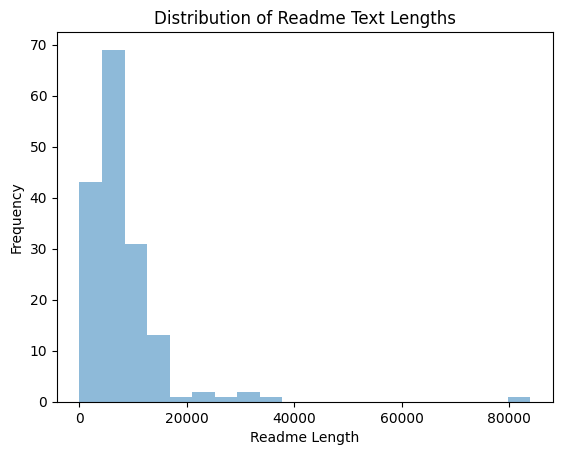

In [36]:
plt.hist(df['readme_length'], bins=20, alpha=0.5)
plt.xlabel('Readme Length')
plt.ylabel('Frequency')
plt.title('Distribution of Readme Text Lengths')
plt.show()

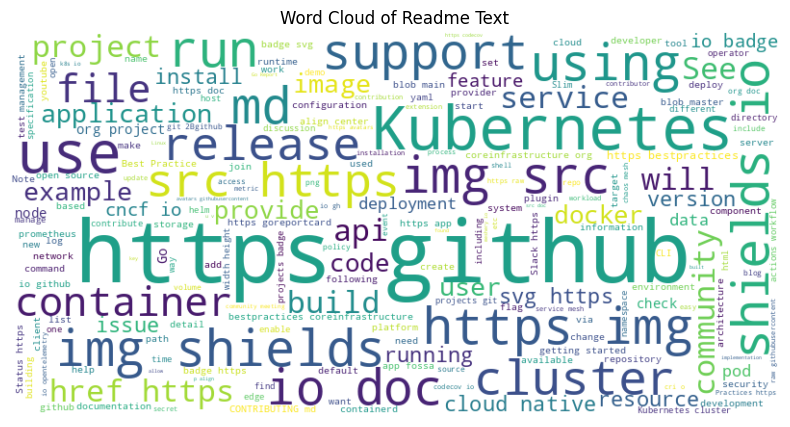

In [35]:
all_text = ' '.join(df['readme_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Readme Text')
plt.show()

We can see that words such as https, github and kubernetes exist a lot and therefore, we can remove those terms during preprocessing


##### Preprocessing

In [37]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokens = nltk.word_tokenize(text)

In [49]:
def preprocess_text(content):
    content = content.lower()

    # remove md codeblocks
    content = re.sub(r'```.*?```', '', content, flags=re.DOTALL)

    content = re.sub(r'<.*?>', '', content) # to remove HTML tags
    
    content = re.sub(r'(https?|ftp)://\S+|www\S+', '', content) # removing urls starting with https, http, www and ftp
    ccontent = re.sub(r'[^\w\s]', '', content) # remove non-alphabetical characters except whitespace

    tokens = nltk.word_tokenize(content)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    tokens = [word for word in tokens if word.isalnum()]

    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # refer to wordcloud. removing words that are irrelevant to the topic
    tokens = [word for word in tokens if word not in ['kubernetes', 'md', 'img', 'src', 'use', 'cluster', 'using', 'file','see', 'please']]

    return " ".join(tokens)

processed_contents = [preprocess_text(content) for content in unpreprocessed_readmes]
processed_contents


['slack channel akri rust version version codecov cii best practice check rust tarpaulin code coverage build controller build agent test k3s microk8s akri cloud native computing foundation cncf sandbox project akri let easily expose heterogeneous leaf device ip camera usb device resource also supporting exposure embedded hardware resource gpus fpgas akri continually detects node access device schedule workload based simply put name akri find akri edge variety sensor controller mcu class device producing data performing action viable edge computing solution heterogeneous leaf device need easily utilized however many leaf device small run akri open source project expose leaf device resource leverage extends device plugin framework created cloud mind focus advertising static resource gpus system hardware akri took framework applied edge diverse set leaf device unique communication protocol intermittent availability akri made edge handling dynamic appearance disappearance leaf device akri 

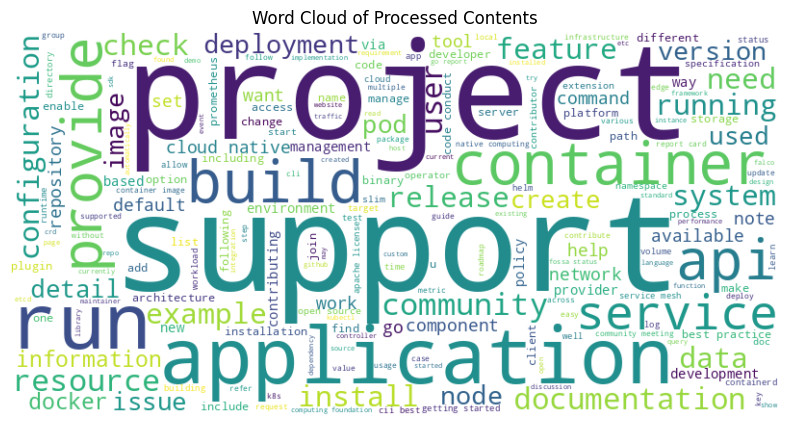

In [50]:
# word clouds to see if there are some other words to remove, then add in list

combined_text = " ".join(processed_contents)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Word Cloud of Processed Contents")
plt.show()

In [51]:
len(processed_contents)

164

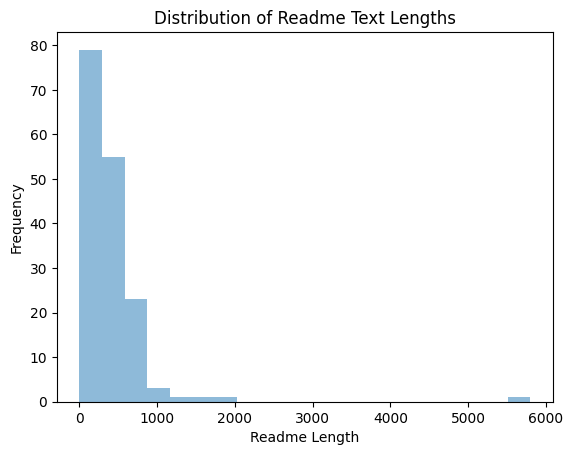

In [52]:
file_lengths = [len(content.split()) for content in processed_contents]
plt.hist(file_lengths, bins=20, alpha=0.5)
plt.xlabel('Readme Length')
plt.ylabel('Frequency')
plt.title('Distribution of Readme Text Lengths')
plt.show()

In [62]:
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_contents)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


top_tfidf_terms = tfidf_df.mean().sort_values(ascending=False)
print("Top TF-IDF Terms:")
print(top_tfidf_terms.head(20))

# these will have the highest tfidf mean scores

Top TF-IDF Terms:
project          0.052326
community        0.050353
license          0.048223
documentation    0.042052
meeting          0.039934
security         0.037010
policy           0.036726
application      0.036581
code             0.036470
build            0.036334
service          0.036081
issue            0.035824
release          0.035712
cncf             0.034852
support          0.033930
resource         0.032760
image            0.032707
container        0.032628
run              0.032490
cloud            0.032286
dtype: float64


In [63]:
tfidf_df.head()

,access,action,add,additional,address,adopter,advanced,aeraki,agent,akri,...,welcome,window,work,workflow,working,workload,write,written,yaml,yes
0,0.00896,0.011467,0.0,0.000000,0.0,0.000000,0.0,0.0,0.047899,0.92445,...,0.008124,0.0,0.023388,0.0,0.000000,0.0096,0.0,0.000000,0.000000,0.0
1,0.00000,0.058950,0.0,0.000000,0.0,0.051505,0.0,0.0,0.000000,0.00000,...,0.041766,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.059784,0.000000,0.0
2,0.04817,0.092476,0.0,0.108931,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.030004,0.0000,0.0,0.031261,0.060813,0.0
3,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.000000,0.0
4,0.00000,0.000000,0.0,0.039120,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.043680,0.0


In [66]:
tfidf_densematrix = tfidf_matrix.toarray()
tfidf_densematrix

array([[0.0089597 , 0.01146702, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05895005, 0.        , ..., 0.05978358, 0.        ,
        0.        ],
       [0.04817048, 0.09247607, 0.        , ..., 0.03126121, 0.06081319,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.07816306, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Now, we will perform LDA

In [76]:
# trying 25
max = 26
coherences = []

dictionary = Dictionary([content.split() for content in processed_contents])
bow_corpus = [dictionary.doc2bow(content.split()) for content in processed_contents]


for i in range(1, max):
    # lda_model = LatentDirichletAllocation(n_components=i, random_state=42)

    lda_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=i, random_state=42)
    # lda_topic_matrix = lda_model.fit_transform(tfidf_df)
    cm = CoherenceModel(model=lda_model, corpus=bow_corpus, texts=[content.split() for content in processed_contents],  coherence='c_v')
    coherence_lda = cm.get_coherence() 

    coherences.append(coherence_lda)

print(coherence_lda)
print(f'COHERENCE SCORES {coherences}')


0.29180676753014695
COHERENCE SCORES [0.2994398157169273, 0.29328701870136453, 0.298229946082003, 0.30142124741264353, 0.29693362543866214, 0.2872683908849873, 0.2870417289856843, 0.297399045999722, 0.2925414088266704, 0.2831773719395804, 0.29294468394734724, 0.2857862819510203, 0.2960424351693944, 0.2960144025839348, 0.28851208338298484, 0.2846217892607864, 0.29810402106545364, 0.29756008502981773, 0.2939548721458304, 0.29033053801951314, 0.2912511154025478, 0.2947436191391631, 0.2853108516705724, 0.2932272675799433, 0.29180676753014695]


Text(0.5, 1.0, 'Coherence Scores for Different Numbers of Topics')

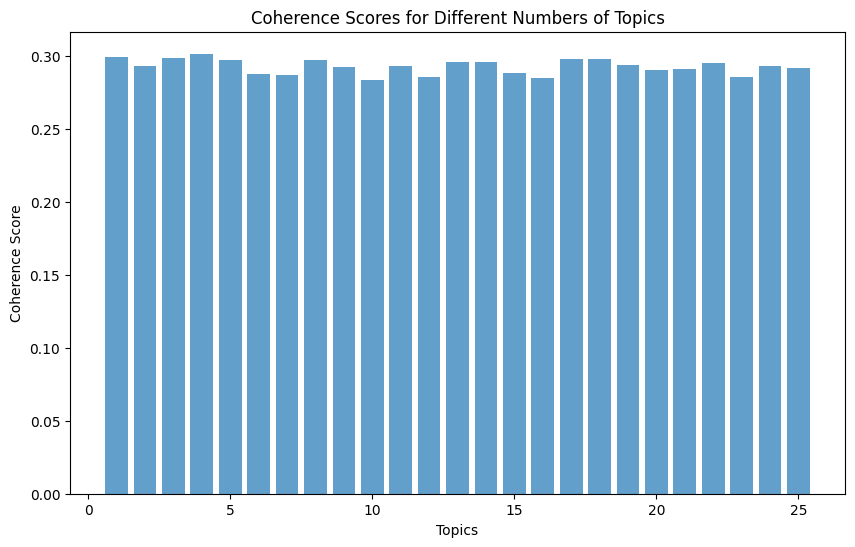

In [78]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, max), coherences, align='center', alpha=0.7)
plt.xlabel('Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Numbers of Topics')

In [87]:
coherence_scores

[0.2994398157169273,
 0.29328701870136453,
 0.298229946082003,
 0.30142124741264353,
 0.29693362543866214,
 0.2872683908849873,
 0.2870417289856843,
 0.297399045999722,
 0.2925414088266704,
 0.2831773719395804,
 0.29294468394734724,
 0.2857862819510203,
 0.2960424351693944,
 0.2960144025839348,
 0.28851208338298484,
 0.2846217892607864,
 0.29810402106545364,
 0.29756008502981773]

Now that we have ideal num_topics value, we can go ahead with our final lda model

In [108]:
num_topics = 4 # based on the above index

In [109]:
final_lda_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=4, random_state=42)

In [137]:
# top words within each topic
def get_top_words(model, num_words=10):
    top_words_per_topic = []
    for topic_idx, topic in model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        top_words = [word for word, _ in topic]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names


array(['access', 'action', 'add', 'additional', 'address', 'adopter',
       'advanced', 'aeraki', 'agent', 'akri', 'allow', 'allows', 'antrea',
       'apache', 'api', 'apis', 'app', 'application', 'apply',
       'architecture', 'argo', 'artifact', 'audit', 'authentication',
       'authorization', 'automatic', 'automatically', 'available', 'aws',
       'azure', 'based', 'best', 'binary', 'block', 'blog', 'branch',
       'bug', 'build', 'building', 'built', 'calendar', 'capability',
       'card', 'case', 'cd', 'certificate', 'change', 'channel', 'chaos',
       'chart', 'chat', 'check', 'ci', 'cii', 'cli', 'client', 'cloud',
       'clusterpedia', 'cncf', 'cni', 'code', 'codecov', 'command',
       'common', 'communication', 'community', 'compatibility',
       'component', 'computing', 'conduct', 'config', 'configuration',
       'configure', 'configured', 'connect', 'contact', 'container',
       'containerd', 'contains', 'content', 'contribute', 'contributing',
       'contribu

In [111]:
num_words = 15
top_words_per_topic = get_top_words(final_lda_model, num_words)
top_words_per_topic

[['project',
  'license',
  'community',
  'container',
  'run',
  'release',
  'issue',
  'service',
  'documentation',
  'application',
  'support',
  'code',
  'security',
  'user',
  'get'],
 ['container',
  'project',
  'license',
  'service',
  'support',
  'application',
  'version',
  'command',
  'community',
  'image',
  'resource',
  'policy',
  'cloud',
  'cncf',
  'run'],
 ['project',
  'container',
  'build',
  'image',
  'run',
  'support',
  'cloud',
  'policy',
  'resource',
  'community',
  'version',
  'license',
  'storage',
  'application',
  'release'],
 ['image',
  'project',
  'run',
  'command',
  'container',
  'service',
  'build',
  'community',
  'support',
  'cloud',
  'application',
  'code',
  'node',
  'version',
  'install']]

Get top 4 topics with top 15 words in each

In [112]:
for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(top_words)}")

Topic 1: project, license, community, container, run, release, issue, service, documentation, application, support, code, security, user, get
Topic 2: container, project, license, service, support, application, version, command, community, image, resource, policy, cloud, cncf, run
Topic 3: project, container, build, image, run, support, cloud, policy, resource, community, version, license, storage, application, release
Topic 4: image, project, run, command, container, service, build, community, support, cloud, application, code, node, version, install


In [126]:
# getting most relevant topics

def get_main_topic(lda_model, corpus, texts):
    main_topics = []

    for i, bow in enumerate(corpus):
        doc_topics = lda_model.get_document_topics(bow)
        
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
        
        main_topic, contribution = sorted_topics[0]

        topic_keywords = ', '.join([word for word, _ in lda_model.show_topic(main_topic)])

        main_topic_label = "Topic " + str(main_topic)
        
        main_topic_info = {
            'Document': i + 1,
            'Main_Topic': main_topic,
            'Main_Topic_Label': main_topic_label, 
            'Percentage': round(contribution, 4),
            'Text': texts[i],
            'Keywords': topic_keywords,
        }
        
        main_topics.append(main_topic_info)

    df_main_topics = pd.DataFrame(main_topics)

    return df_main_topics

df_topics = get_main_topic(lda_model=final_lda_model, corpus=bow_corpus, texts=processed_contents)
print(df_topics.head())


   Document  Main_Topic Main_Topic_Label  Percentage  \
0         1           3          Topic 3      0.7593   
1         2           0          Topic 0      0.9974   
2         3           2          Topic 2      0.9987   
3         4           1          Topic 1      0.7434   
4         5           3          Topic 3      0.9408   

                                                Text  \
0  slack channel akri rust version version codeco...   
1  cloud development kit website view construct h...   
2  cloud custodian c7n slack ci cii best practice...   
3                                  devstream updated   
4  kpt automate configuration editing kpt toolcha...   

                                            Keywords  
0  image, project, run, command, container, servi...  
1  project, license, community, container, run, r...  
2  project, container, build, image, run, support...  
3  container, project, license, service, support,...  
4  image, project, run, command, container, servi..

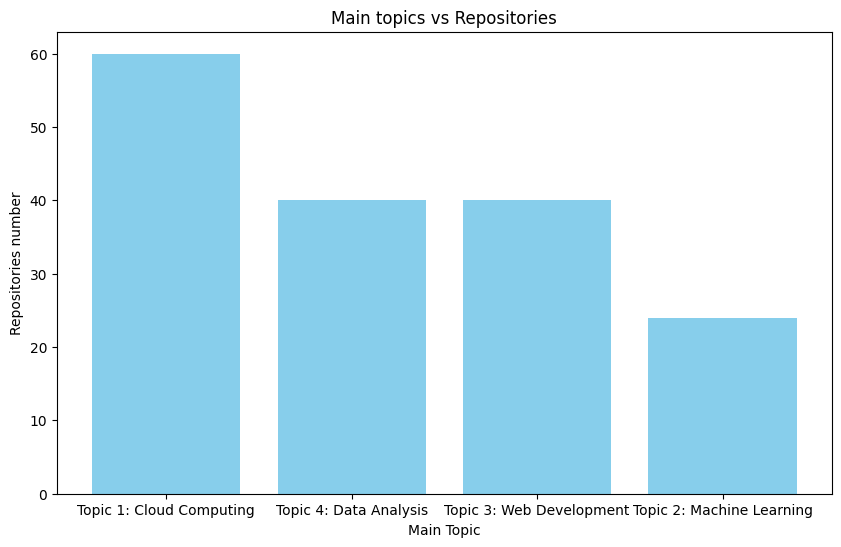

In [138]:
topic_counts = df_topics['Main_Topic'].apply(lambda x: topic_labels[x]).value_counts()

# Create a bar chart to visualize the distribution of repositories across topics
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.index, topic_counts.values, color='skyblue')
plt.xlabel('Main Topic')
plt.ylabel('Repositories number')
plt.title('Main topics vs Repositories')
plt.xticks(topic_counts.index)
plt.show()

In [132]:
topic_label_counts

Topic 1: Cloud Computing     60
Topic 3: Web Development     41
Topic 4: Data Analysis       39
Topic 2: Machine Learning    24
Name: Main_Topic, dtype: int64

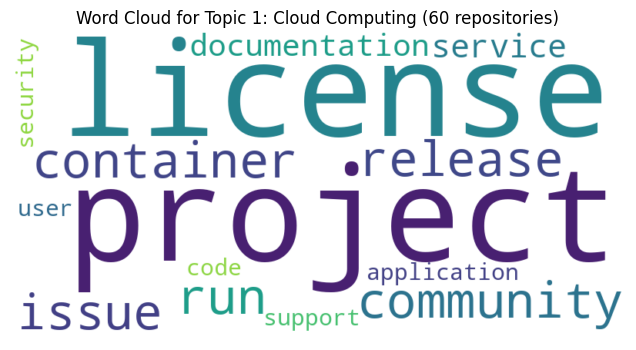

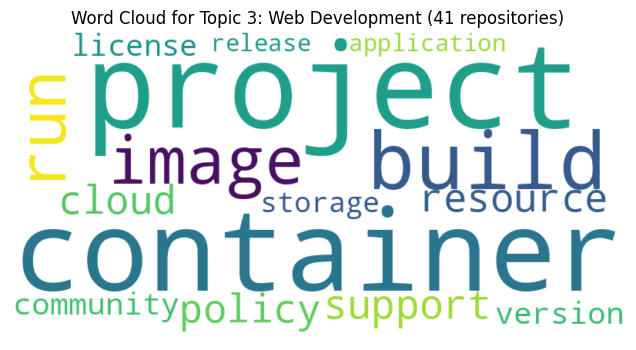

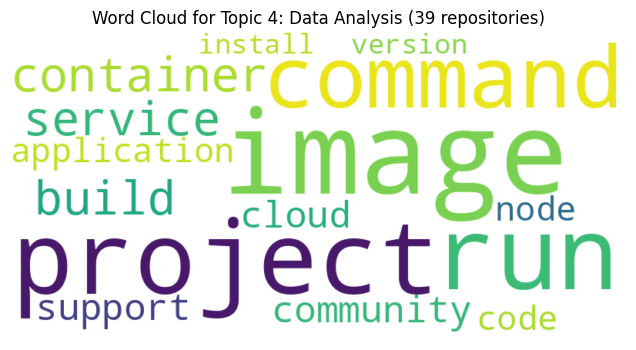

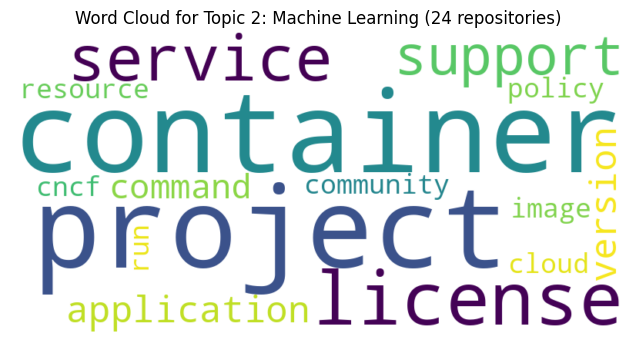

In [135]:
# creating a word cloud for each topic
for topic_label, count in topic_label_counts.items():
    topic_number = int(topic_label.split(':')[0].strip().split()[-1])

    keywords = top_words_per_topic[topic_number - 1] 
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {topic_label} ({count} repositories)')
    plt.axis('off')
    plt.show()


Heatmap

C:\Users\GJ\AppData\Local\Temp\ipykernel_17528\322414474.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df_topics.pivot("Document", "Main_Topic_Label", "Percentage")


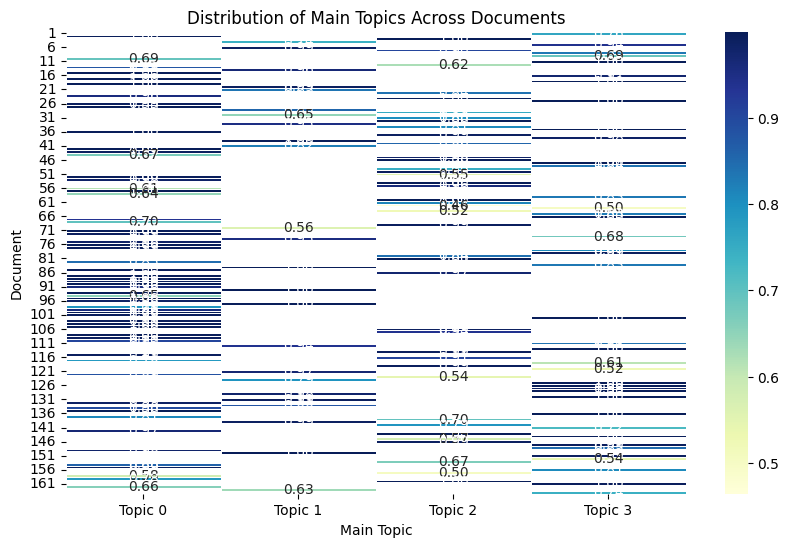

In [144]:
heatmap_data = df_topics.pivot("Document", "Main_Topic_Label", "Percentage")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=.5)
plt.title('Distribution of Main Topics Across Documents')
plt.xlabel('Main Topic')
plt.ylabel('Document')
plt.show()

In [136]:
!pip freeze > requirements.txt

Finished!